## SIAC filtering with FBP on noiseless Phantom

# CHECK dtype for float32 or float 64, decide on ONE

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import odl

import sys
sys.path.append("..")

from src.tomo import (
    make_space_2d,
    shepp_logan_2d,
    parallel_geom_2d,
    ray_transform_2d,
    reconstruct_bp,
    reconstruct_fbp,
)


### 2D Shepp Logan Phantom

/home/ahopkins/KTH_TTMAM/MEX/odl_xray/venv/lib/python3.10/site-packages/odl/util/utility.py:1398: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_requirements


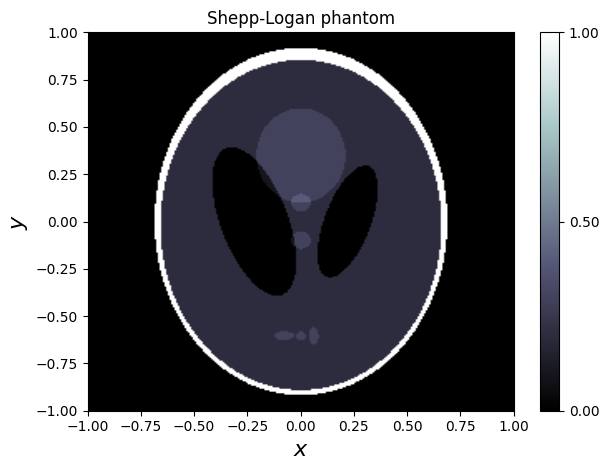

<Figure size 640x480 with 0 Axes>

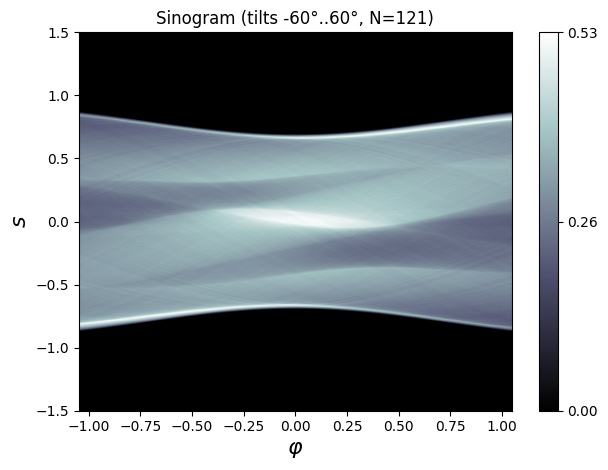

<Figure size 640x480 with 0 Axes>

In [4]:
space = make_space_2d(Nx=256, Ny=256, domain=[-1, 1, -1, 1])
phantom = shepp_logan_2d(space)
phantom_np = phantom.asarray()

angular_coverage=(-60,60)
step = 1
geom = parallel_geom_2d(angular_coverage=angular_coverage, step=step, 
                        det_range=(-1.5, 1.5), det_count=400)
A = ray_transform_2d(space, geom)
data_space = A.range

sinogram = A(phantom)

phantom.show(title="Shepp-Logan phantom")

sinogram.show(title=f"Sinogram (tilts {angular_coverage[0]}°..{angular_coverage[1]}°, N={int((angular_coverage[1] - angular_coverage[0]) / step) + 1})")
plt.show()

### Fourier SIAC filter with the FBP

**Regular FBP**
\begin{align*}
    \text{FBP} = A^* \mathcal{F}^{-1}\big[ |\omega|W(\omega) \mathcal{F}[\cdot] \big]
\end{align*}

Where $A^*$ is the adjoint to the X-ray transform, $\mathcal{F}$ is the Fourier transform and $W$ is a window (e.g. Shepp-Logan or Hann).

**FBP with SIAC**
\begin{align*}
    \text{FBP} = A^* \mathcal{F}^{-1}\big[ \underbrace{|\omega|W(\omega)}_{\text{standard FBP}} \underbrace{\widehat{S}(\omega)}_{\text{SIAC}} \mathcal{F}[\cdot] \big]
\end{align*}

**Note** Much code reused from Jennifer Ryans notebook: 
$\texttt{"FourierFilterIntro-Entire.ipynb"}$

A **sepereable** 2D frequency filter has the form:
$$
    \widehat{S}(\omega_x, \omega_y) = \widehat{S}_x(\omega_x) \cdot \widehat{S}_y(\omega_y)
$$
so it can be interpreted as applying a 1D filter in the $x$-direction and a 1D filter in $y$-direction (in the Fourier domain).

We **pad** the image before FFT-based filtering to avoid edge artifacts. FFT-based convolution assumes the input is periodic, meaning the left/right and top/bottom edges are implicitly “wrapped together”. Padding creates a buffer region so the effective convolution support does not reach the artificial periodic boundary, and we then crop back to the original field of view.

The padding itself only has to be slightly larger than the effective support of the SIAC kernel (radius). Since it is a B-spline of order $n$, it has support of width $n+1$, with the shifts $\gamma = 0, \ldots, r$ spanning a range of length $\sim r$. Thus we pad a distance of
$$
    R_{\text{pad}} \approx \frac{r+n+1}{2}
$$
in grid voxels (approximately the radius of the kernel).

### Fourier Form of Filter

The Fourier Form of the filter consisting of $r+1$ B-Splines of order $n$ is 
$$\sigma(\omega_n) = \left(\frac{\sin(\omega_n/2)}{\omega_n/2}\right)^n\left(c_0 + 2\sum_{\gamma = 0}^r\, c_\gamma \cos(\gamma\omega_n))\right)$$

**Incorporating Noise**

In [5]:
from src.tomo import add_poisson_noise, add_gaussian_noise, add_poisson_gaussian_noise

I0 = 2e4
# sino_noisy = add_poisson_noise(sino, A, I0=I0)
# sino_noisy = add_gaussian_noise(sino, A, I0=I0, sigma=3.0)
sino_noisy = add_poisson_gaussian_noise(sinogram, A, I0=I0, sigma=2.0)


**Find best frequency filter for noise level (best FBP solution)**
* Measured in relative $L^2$-error against the true phantom

In [6]:
from src.metrics import rel_l2_err
# Find the best FBP solution by looping over all filters, measured by relative L2
error = np.inf
for filter in ["Ram-Lak", "Shepp-Logan", "Cosine", "Hamming", "Hann"]:
    temp = reconstruct_fbp(sino_noisy, A, filter_name=filter)
    temp = temp.asarray()
    temp_error = rel_l2_err(x=temp, xtrue=phantom_np)
    if temp_error < error:
        fbp_best = temp
        error = temp_error
        best_filter = filter

# Reference solution is the FBP with ramp filter (Ram-Lak)
fbp_ref = reconstruct_fbp(sino_noisy, A, filter_name="Ram-Lak")
fbp_ref = fbp_ref.asarray()

### Computing the results

In [7]:
from src.siac import apply_siac_fft_nd

# dx = space.cell_sides[0]
# dy = space.cell_sides[1]

dx, dy = space.cell_sides           # physical grid spacing (x, y)
_, d_det = data_space.cell_sides    # (angular res (rad), detector spacing)

Ny, Nx = phantom_np.shape


moments = 2
BSorder = 2

# Apply SIAC after FBP with ramp filter
fbp_siac_img_space = apply_siac_fft_nd(arr=fbp_ref, 
                                       h_per_axis=(dy, dx), 
                                       axes=(0, 1), 
                                       moments=moments, 
                                       BSorder=BSorder, 
                                       pad_mode="reflect")
# Apply SIAC in dataspace to detector coordinate
sino_np = sino_noisy.asarray()          # (angles, detectors)
sino_np_siac = apply_siac_fft_nd(arr=sino_np, 
                                 h_per_axis = d_det, 
                                 axes=(1), 
                                 moments=moments, 
                                 BSorder=BSorder, 
                                 pad_mode="reflect"
                                 )
sino_odl_siac = data_space.element(sino_np_siac)
fbp_siac_dataspace = reconstruct_fbp(sino_odl_siac, A, filter_name="Ram-Lak")
fbp_siac_dataspace = fbp_siac_dataspace.asarray()

# Apply SIAC both in dataspace and after FBP
fbp_siac_both = apply_siac_fft_nd(arr=fbp_siac_dataspace, 
                                       h_per_axis=(dy, dx), 
                                       axes=(0, 1), 
                                       moments=moments, 
                                       BSorder=BSorder, 
                                       pad_mode="reflect")


**Plotting side by side**

In [8]:
def crop(img, y0, y1, x0, x1):
    return img[y0:y1, x0:x1]

def plot_grid(images, titles, ncols=3, figsize=(12, 8), vmin=None, vmax=None):
    n = len(images)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, constrained_layout=True)
    axes = np.atleast_1d(axes).ravel()

    for i in range(n):
        ax = axes[i]
        im = ax.imshow(images[i], cmap="gray", vmin=vmin, vmax=vmax)
        ax.set_title(titles[i])
        ax.axis("off")

    # turn off unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    return fig


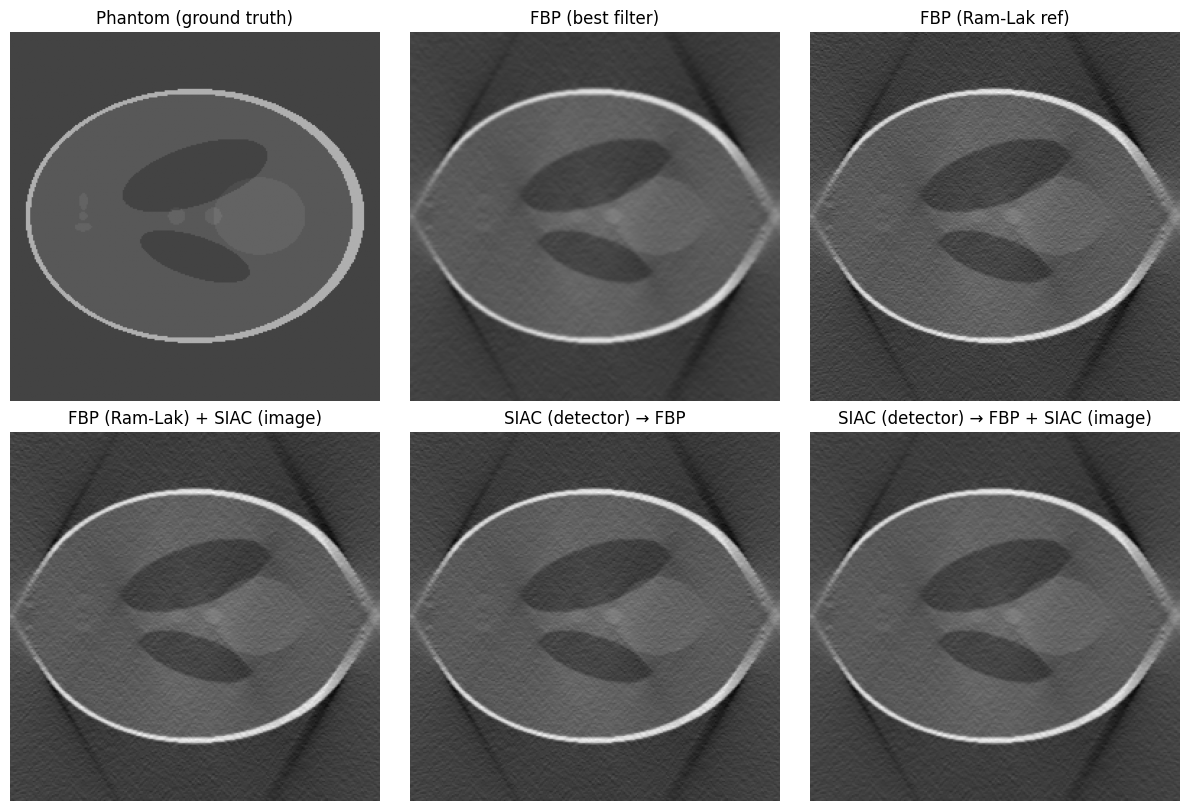

In [9]:
images = [
    phantom_np,
    fbp_best,
    fbp_ref,
    fbp_siac_img_space,
    fbp_siac_dataspace,
    fbp_siac_both
]

titles = [
    "Phantom (ground truth)",
    "FBP (best filter)",
    "FBP (Ram-Lak ref)",
    "FBP (Ram-Lak) + SIAC (image)",
    "SIAC (detector) → FBP",
    "SIAC (detector) → FBP + SIAC (image)"
]

vmin = min(img.min() for img in images)
vmax = max(img.max() for img in images)

fig = plot_grid(images, titles, ncols=3, figsize=(12, 8), vmin=vmin, vmax=vmax)
plt.show()


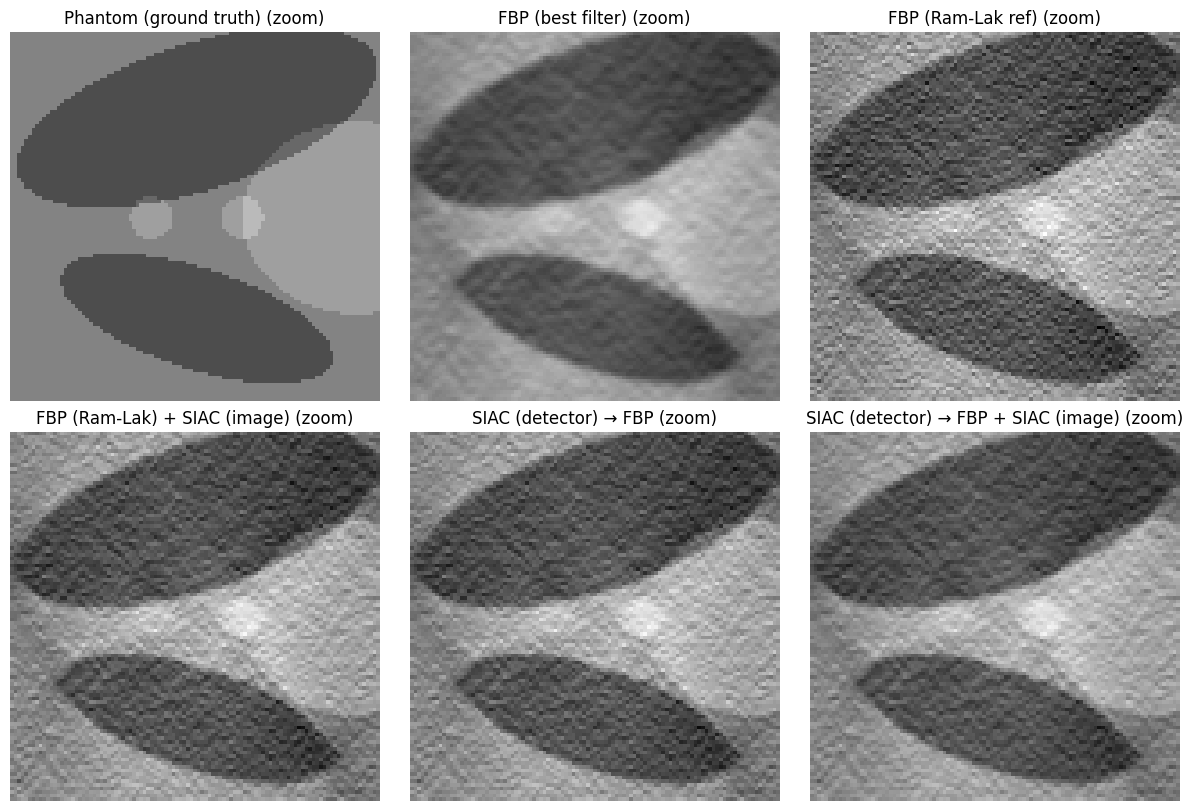

In [10]:
Ny, Nx = phantom_np.shape

x0 = int(0.30 * Nx)
x1 = int(0.70 * Nx)
y0 = int(0.30 * Ny)
y1 = int(0.70 * Ny)

images_zoom = [crop(img, y0, y1, x0, x1) for img in images]

vmin_z = min(img.min() for img in images_zoom)
vmax_z = max(img.max() for img in images_zoom)

fig = plot_grid(images_zoom, [t + " (zoom)" for t in titles],
                ncols=3, figsize=(12, 8), vmin=vmin_z, vmax=vmax_z)
plt.show()



**Computing metrics for each solution**

In [11]:
import pandas as pd
from src.metrics import highfreq_removed_energy, gradient_error, rel_l2_err, removed_energy, ssim

def compute_metrics_table(solutions: dict,
                          truth: np.ndarray,
                          baseline: np.ndarray,
                          dx: float, dy: float,
                          hf_frac: float = 0.6):
    rows = []

    for name, img in solutions.items():
        img = np.asarray(img, dtype=np.float64)

        # --- quality vs truth ---
        l2 = rel_l2_err(img, truth)
        gerr = gradient_error(img, truth, dx=dx, dy=dy)

        row = {
            "name": name,
            "rel_L2_vs_truth": l2,
            "rel_grad_L2_vs_truth": gerr,
            "SSIM_vs_truth": ssim(img, truth),
        }

        # --- "removed energy" metrics vs baseline (only meaningful for SIAC variants applied to baseline)
        # Decide which ones should be compared to baseline:
        is_siac_variant = name.startswith("SIAC")
        if is_siac_variant:
            Erem, Erel = removed_energy(baseline, img)
            Ehf, Ehf_rel_total, Ehf_rel_hf = highfreq_removed_energy(
                baseline, img, dx=dx, dy=dy, frac=hf_frac
            )
            row.update({
                "removed_E": Erem,
                "removed_E_rel": Erel,
                "removed_HF_E": Ehf,
                "removed_HF_E_rel_total": Ehf_rel_total,
                "removed_HF_E_rel_HF": Ehf_rel_hf,
            })
        else:
            # leave as NaN for non-operator comparisons
            row.update({
                "removed_E": np.nan,
                "removed_E_rel": np.nan,
                "removed_HF_E": np.nan,
                "removed_HF_E_rel_total": np.nan,
                "removed_HF_E_rel_HF": np.nan,
            })

        rows.append(row)

    df = pd.DataFrame(rows).set_index("name")
    return df


In [12]:
solutions = {
    "Phantom": phantom_np,
    "FBP best": fbp_best,
    "FBP ref (Ram-Lak)": fbp_ref,
    "SIAC after FBP (img)": fbp_siac_img_space,
    "SIAC on detector → FBP": fbp_siac_dataspace,
    "SIAC both": fbp_siac_both,
}

df = compute_metrics_table(
    solutions=solutions,
    truth=phantom_np,
    baseline=fbp_ref,
    dx=dx, dy=dy,
    hf_frac=0.6
)

pd.options.display.float_format = "{:.3e}".format
cols = [
    "rel_L2_vs_truth",
    "rel_grad_L2_vs_truth",
    "SSIM_vs_truth",
    "removed_E_rel",
    "removed_HF_E_rel_HF",
]
print(df[cols].sort_values("rel_L2_vs_truth"))



                        rel_L2_vs_truth  rel_grad_L2_vs_truth  SSIM_vs_truth  \
name                                                                           
Phantom                       0.000e+00             1.850e-09      1.000e+00   
FBP best                      5.230e-01             6.883e-01      3.523e-01   
SIAC both                     5.476e-01             7.739e-01      2.351e-01   
SIAC on detector → FBP        5.560e-01             8.129e-01      2.104e-01   
SIAC after FBP (img)          5.569e-01             8.213e-01      2.088e-01   
FBP ref (Ram-Lak)             5.751e-01             8.960e-01      1.808e-01   

                        removed_E_rel  removed_HF_E_rel_HF  
name                                                        
Phantom                           NaN                  NaN  
FBP best                          NaN                  NaN  
SIAC both                   9.787e-03            3.495e-01  
SIAC on detector → FBP      3.547e-03            1.283

**Additional plots**

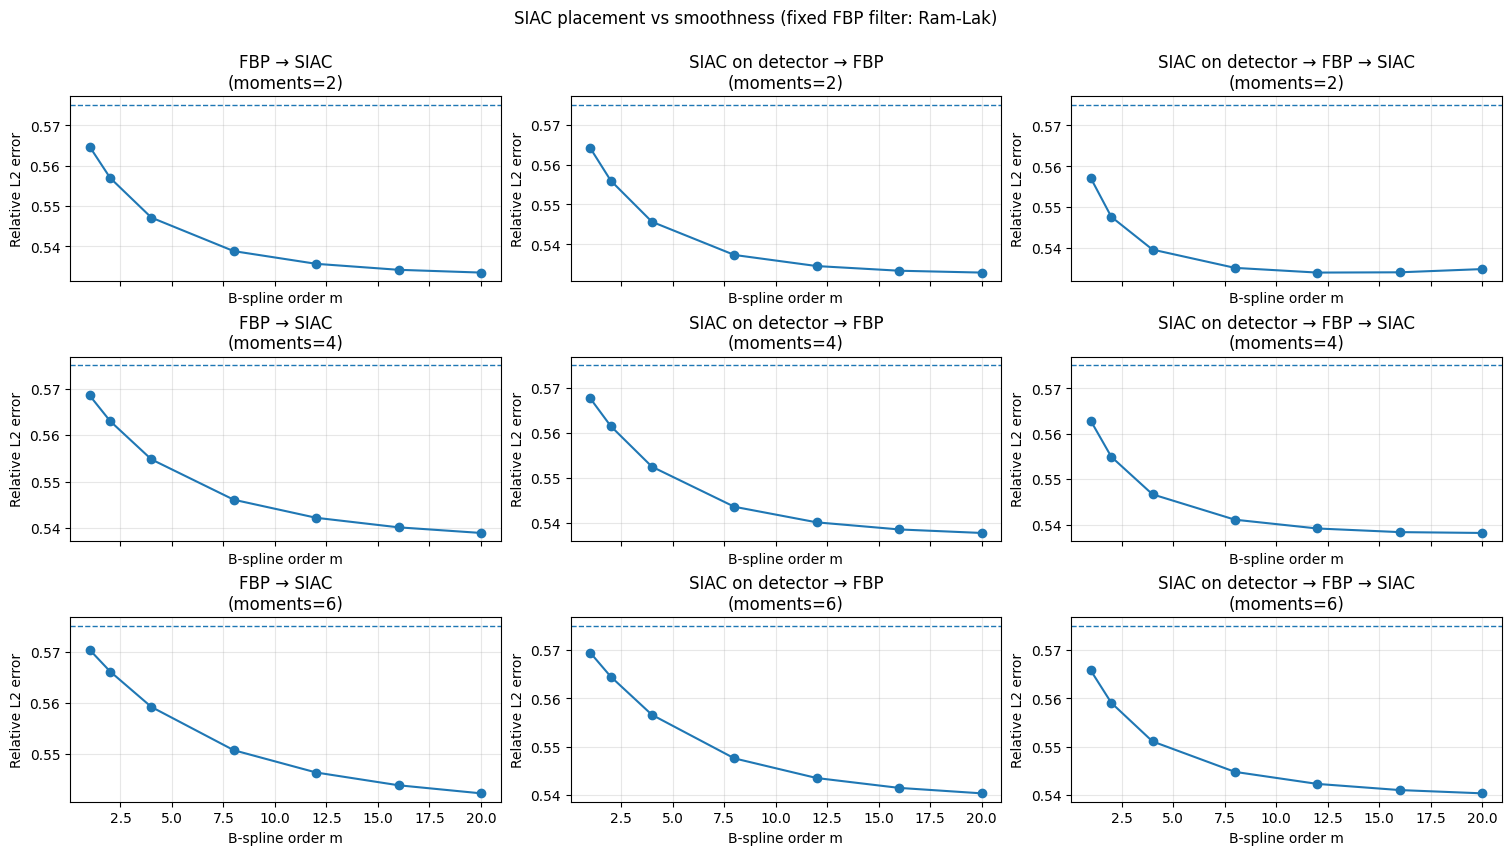

In [13]:

dx, dy = space.cell_sides
_, d_det = data_space.cell_sides  # (dtheta, detector spacing)

BSorders = [1, 2, 4, 8, 12, 16, 20]
moments_list = [2, 4, 6]  # r values

filter_used = "Ram-Lak"

def fbp_after_detector_siac(sino_np_filtered):
    """Helper: take numpy sinogram -> ODL element -> FBP -> numpy image."""
    sino_odl = data_space.element(sino_np_filtered)
    recon_odl = reconstruct_fbp(sino_odl, A, filter_name=filter_used)
    return recon_odl.asarray()

def eval_pipeline_errors(moments, BSorders):
    """
    Returns three lists of errors vs BSorder:
      1) SIAC after FBP (image space)
      2) SIAC on detector axis then FBP
      3) SIAC on detector axis then FBP then SIAC after FBP
    """
    errs_img = []
    errs_det = []
    errs_both = []

    for m in BSorders:
        # 1) SIAC after FBP (image space), starting from fbp_ref
        img_siac = apply_siac_fft_nd(
            arr=fbp_ref,
            h_per_axis=(dy, dx),
            axes=(0, 1),
            moments=moments,
            BSorder=m,
            pad_mode="reflect"
        )
        errs_img.append(rel_l2_err(img_siac, phantom_np))

        # 2) SIAC on detector axis then FBP
        sino_siac = apply_siac_fft_nd(
            arr=sino_np,
            h_per_axis=d_det,
            axes=(1,),
            moments=moments,
            BSorder=m,
            pad_mode="reflect"
        )
        fbp_det = fbp_after_detector_siac(sino_siac)
        errs_det.append(rel_l2_err(fbp_det, phantom_np))

        # 3) Both: detector SIAC -> FBP -> image SIAC
        fbp_both = apply_siac_fft_nd(
            arr=fbp_det,
            h_per_axis=(dy, dx),
            axes=(0, 1),
            moments=moments,
            BSorder=m,
            pad_mode="reflect"
        )
        errs_both.append(rel_l2_err(fbp_both, phantom_np))

    return errs_img, errs_det, errs_both

# --- compute and plot ---
fig, axes = plt.subplots(len(moments_list), 3, figsize=(15, 8), constrained_layout=True, sharex=True)

pipelines = [
    ("FBP → SIAC", 0),
    ("SIAC on detector → FBP", 1),
    ("SIAC on detector → FBP → SIAC", 2),
]

for row, r in enumerate(moments_list):
    errs_img, errs_det, errs_both = eval_pipeline_errors(r, BSorders)
    all_errs = [errs_img, errs_det, errs_both]

    # Optional: baseline line (no SIAC)
    baseline_err = rel_l2_err(fbp_ref, phantom_np)

    for title, col in pipelines:
        ax = axes[row, col] if len(moments_list) > 1 else axes[col]
        ax.plot(BSorders, all_errs[col], marker="o")
        ax.axhline(baseline_err, linestyle="--", linewidth=1.0)
        ax.set_title(f"{title}\n(moments={r})")
        ax.set_xlabel("B-spline order m")
        ax.set_ylabel("Relative L2 error")
        ax.grid(True, alpha=0.3)

plt.suptitle(f"SIAC placement vs smoothness (fixed FBP filter: {filter_used})", y=1.05)
plt.show()


**Alpha sweep and plot: relative $L^2$ vs $\alpha$**

Before we did:
$$
    \tilde u = \mathcal{S}(u)
$$

Now we do a sweep with $\alpha \in [-1,1]$
$$
    u^* = u + \alpha \big(\mathcal{S}(u) - u\big)
$$

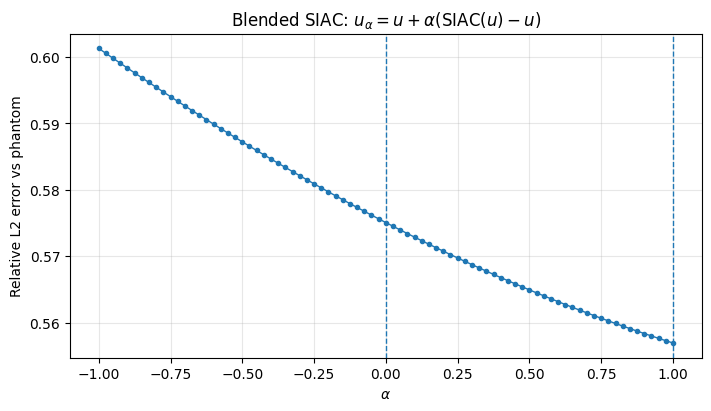

Best alpha (in sweep): 1.0
Best rel L2 error: 0.556924220251
Baseline (alpha=0): 0.575056185478
Full SIAC (alpha=1): 0.556924220251


In [14]:

def alpha_blend(u, u_siac, alpha):
    # u_alpha = (1-alpha)*u + alpha*u_siac
    return u + alpha * (u_siac - u)

# Choose alphas (dense grid)
alphas = np.linspace(-1.0, 1.0, 81)

errs = []
for a in alphas:
    u_a = alpha_blend(fbp_ref, fbp_siac_img_space, a)
    errs.append(rel_l2_err(u_a, phantom_np))

errs = np.asarray(errs)

plt.figure(figsize=(7,4), constrained_layout=True)
plt.plot(alphas, errs, marker="o", markersize=3, linewidth=1)
plt.axvline(0.0, linestyle="--", linewidth=1)
plt.axvline(1.0, linestyle="--", linewidth=1)
plt.xlabel(r"$\alpha$")
plt.ylabel("Relative L2 error vs phantom")
plt.title(r"Blended SIAC: $u_\alpha = u + \alpha(\mathrm{SIAC}(u)-u)$")
plt.grid(True, alpha=0.3)
plt.show()

# Optional: report best alpha in the sweep
i_best = int(np.argmin(errs))
print("Best alpha (in sweep):", alphas[i_best])
print("Best rel L2 error:", errs[i_best])
print("Baseline (alpha=0):", errs[np.argmin(np.abs(alphas-0.0))])
print("Full SIAC (alpha=1):", errs[np.argmin(np.abs(alphas-1.0))])

**Alpha sweep and plot: gradient error**

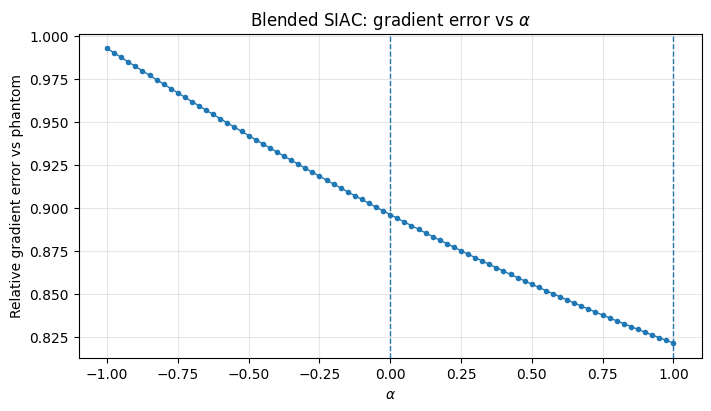

In [15]:
dx, dy = space.cell_sides

gerrs = []
for a in alphas:
    u_a = alpha_blend(fbp_ref, fbp_siac_img_space, a)
    gerrs.append(gradient_error(u_a, phantom_np, dx=dx, dy=dy))

gerrs = np.asarray(gerrs)

plt.figure(figsize=(7,4), constrained_layout=True)
plt.plot(alphas, gerrs, marker="o", markersize=3, linewidth=1)
plt.axvline(0.0, linestyle="--", linewidth=1)
plt.axvline(1.0, linestyle="--", linewidth=1)
plt.xlabel(r"$\alpha$")
plt.ylabel("Relative gradient error vs phantom")
plt.title(r"Blended SIAC: gradient error vs $\alpha$")
plt.grid(True, alpha=0.3)
plt.show()
